# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [1]:
# Установка библиотек (если требуется)
%pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [2]:
# Ваш код здесь
# Сначала определим данные
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)

# 2. Преобразуйте столбец 'Дата'
df['Дата'] = pd.to_datetime(df['Дата'])

# 3. Выведите информацию о DataFrame
print("Информация о DataFrame:")
df.info()

print("\nПервые 5 строк DataFrame:")
print(df.head())

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 152.0 bytes

Первые 5 строк DataFrame:
        Дата  Продажи
0 2023-01-01     1000
1 2023-02-01     1200
2 2023-03-01     1300
3 2023-04-01     1100
4 2023-05-01     1400


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [3]:
# === ЗАДАНИЕ 2 ===
print("\n=== ЗАДАНИЕ 2 ===")
# Установка временного индекса
df.set_index('Дата', inplace=True)
print("DataFrame после установки индекса:")
print(df)


=== ЗАДАНИЕ 2 ===
DataFrame после установки индекса:
            Продажи
Дата               
2023-01-01     1000
2023-02-01     1200
2023-03-01     1300
2023-04-01     1100
2023-05-01     1400


**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [4]:
# === ЗАДАНИЕ 3 ===
print("\n=== ЗАДАНИЕ 3 ===")
# Фильтрация данных по дате
df_filtered = df['2023-03':'2023-04']
print("Данные за период с марта по апрель 2023 года:")
print(df_filtered)


=== ЗАДАНИЕ 3 ===
Данные за период с марта по апрель 2023 года:
            Продажи
Дата               
2023-03-01     1300
2023-04-01     1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [5]:
# === ЗАДАНИЕ 4 ===
print("\n=== ЗАДАНИЕ 4 ===")
# Обнаружение пропущенных значений
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Посчитайте пропущенные значения
missing_count = df_missing.isnull().sum()
print("Количество пропущенных значений в каждом столбце:")
print(missing_count)
print("\nDataFrame с пропущенными значениями:")
print(df_missing)


=== ЗАДАНИЕ 4 ===
Количество пропущенных значений в каждом столбце:
Продажи    1
dtype: int64

DataFrame с пропущенными значениями:
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01      NaN
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [6]:
# === ЗАДАНИЕ 5 ===
print("\n=== ЗАДАНИЕ 5 ===")
# Заполнение пропусков средним значением
# 1. Рассчитайте среднее по столбцу 'Продажи'
sales_mean = df_missing['Продажи'].mean()
print(f"Среднее значение продаж: {sales_mean}")

# 2. Заполните пропуски с помощью .fillna()
df_missing_filled = df_missing.fillna({'Продажи': sales_mean})
print("\nDataFrame после заполнения средним значением:")
print(df_missing_filled)


=== ЗАДАНИЕ 5 ===
Среднее значение продаж: 1200.0

DataFrame после заполнения средним значением:
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1200.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [7]:
# === ЗАДАНИЕ 6 ===
print("\n=== ЗАДАНИЕ 6 ===")
# Заполнение пропусков методом интерполяции
# Сначала восстановим оригинальный df_missing с пропуском
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Примените метод .interpolate() к df_missing
df_missing_interpolated = df_missing.interpolate()
print("DataFrame после интерполяции:")
print(df_missing_interpolated)


=== ЗАДАНИЕ 6 ===
DataFrame после интерполяции:
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1150.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [8]:
# Сначала установим requests если нужно
try:
    import requests
except:
    !pip install requests -q
    import requests

# === ЗАДАНИЕ 7 ===
print("\n=== ЗАДАНИЕ 7 ===")

gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

try:
    # Загружаем данные с помощью requests
    response = requests.get(gas_url)
    
    # Проверяем статус ответа
    if response.status_code == 200:
        # Создаем DataFrame из текста ответа
        from io import StringIO
        gas_df = pd.read_csv(StringIO(response.text), parse_dates=['date'], index_col='date')
        
        # Выведите первые 5 строк
        print("Первые 5 строк данных:")
        print(gas_df.head())
        
        # Проверим информацию о данных
        print("\nИнформация о данных:")
        gas_df.info()
    else:
        print(f"Ошибка HTTP: {response.status_code}")
        
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")


=== ЗАДАНИЕ 7 ===
Первые 5 строк данных:
            value
date             
1991-02-03  6.621
1991-02-10  6.433
1991-02-17  6.582
1991-02-24  7.224
1991-03-03  6.875

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1355 entries, 1991-02-03 to 2017-01-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1355 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.


=== ЗАДАНИЕ 8 ===


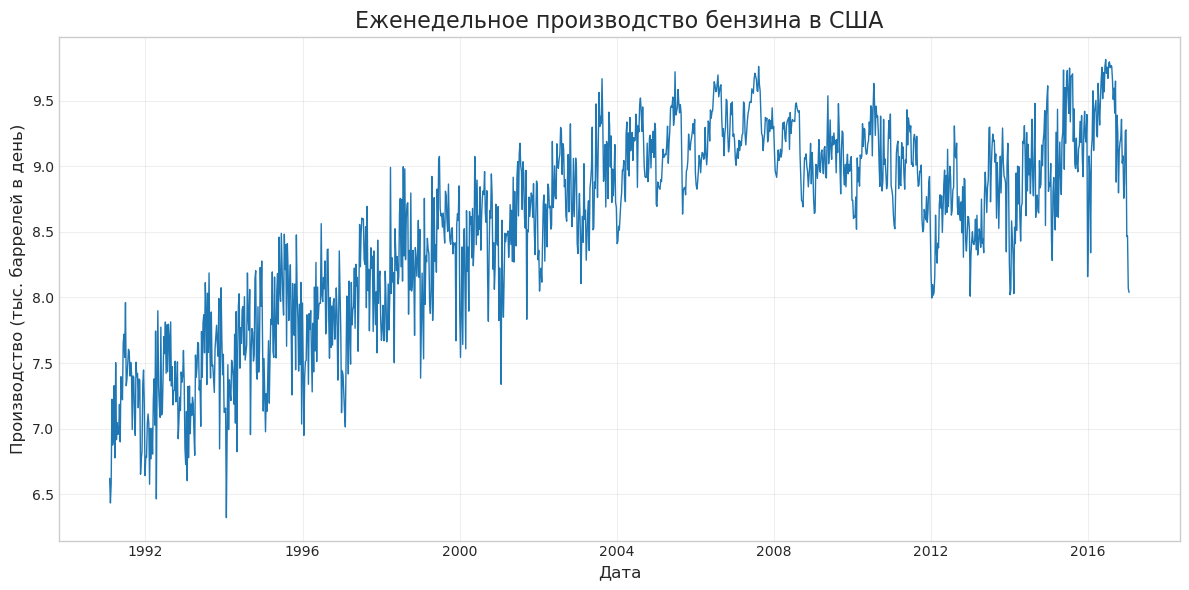

In [9]:
# === ЗАДАНИЕ 8 ===
print("\n=== ЗАДАНИЕ 8 ===")
# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(gas_df.index, gas_df['value'], linewidth=1)
plt.title('Еженедельное производство бензина в США', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.


=== ЗАДАНИЕ 9 ===


<ipython-input-10-cbeff2691501>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas_df.resample('M').mean()


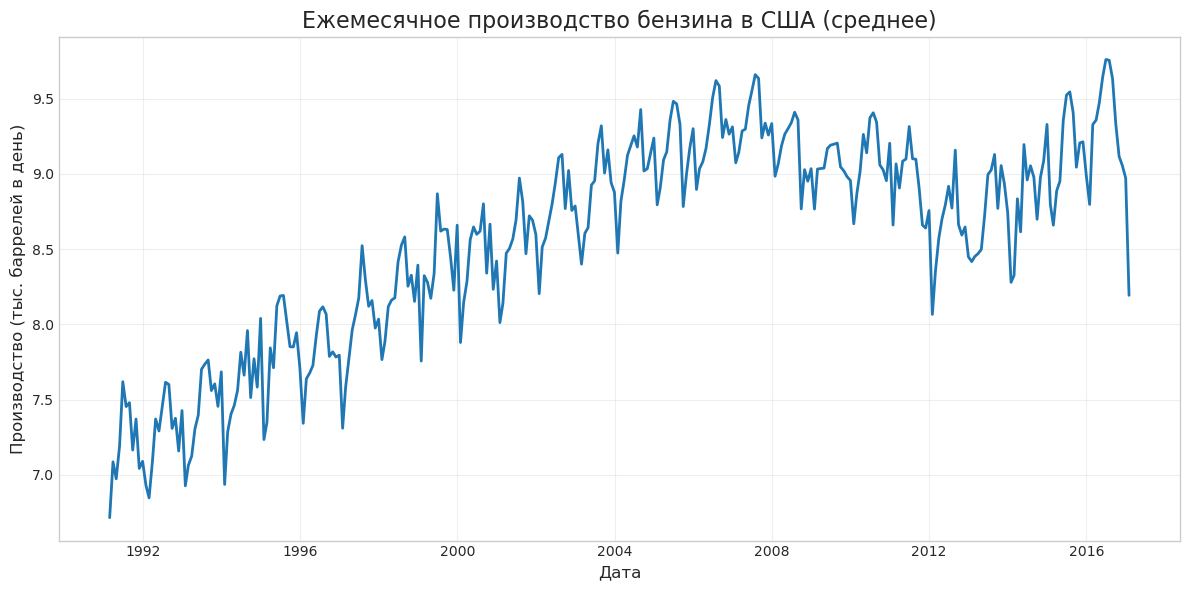

Первые 5 строк ежемесячных данных:
              value
date               
1991-02-28  6.71500
1991-03-31  7.08600
1991-04-30  6.97325
1991-05-31  7.19175
1991-06-30  7.61900


In [10]:
# === ЗАДАНИЕ 9 ===
print("\n=== ЗАДАНИЕ 9 ===")
# Ресэмплинг для агрегации данных
# 1. Выполните ресэмплинг
gas_monthly = gas_df.resample('M').mean()

# 2. Постройте график для gas_monthly['value']
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], linewidth=2)
plt.title('Ежемесячное производство бензина в США (среднее)', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Первые 5 строк ежемесячных данных:")
print(gas_monthly.head())

**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

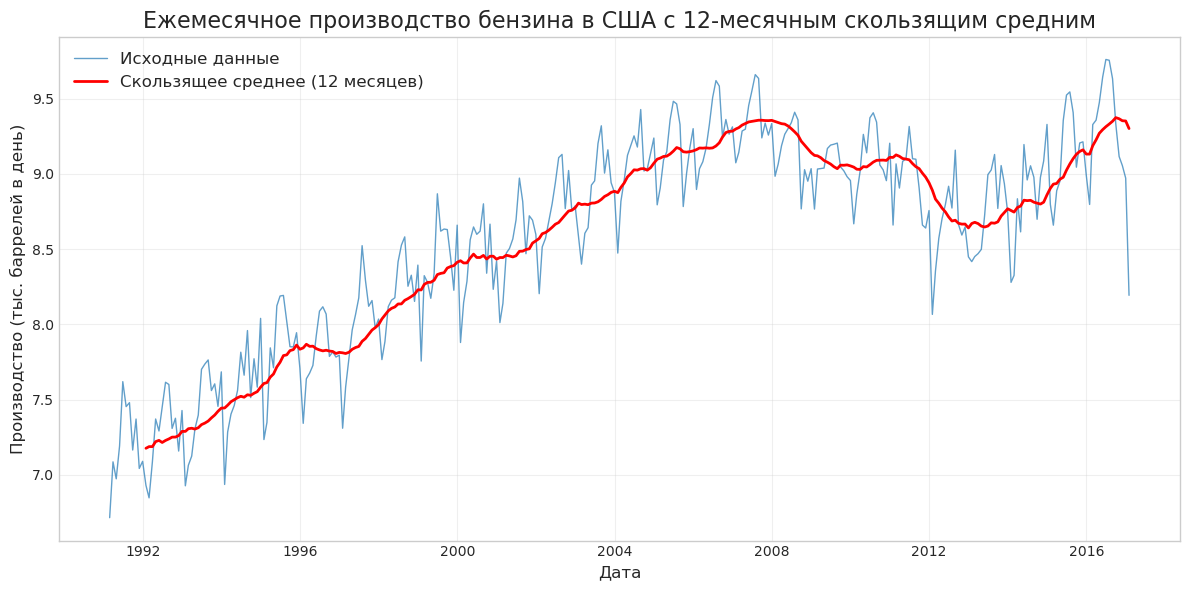

In [11]:
# Ваш код здесь
# 1. Рассчитайте скользящее среднее
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()

# 2. Постройте оба графика
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исходные данные', linewidth=1, alpha=0.7)
plt.plot(gas_monthly.index, gas_monthly['rolling_mean_12'], label='Скользящее среднее (12 месяцев)', 
         linewidth=2, color='red')
plt.title('Ежемесячное производство бензина в США с 12-месячным скользящим средним', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

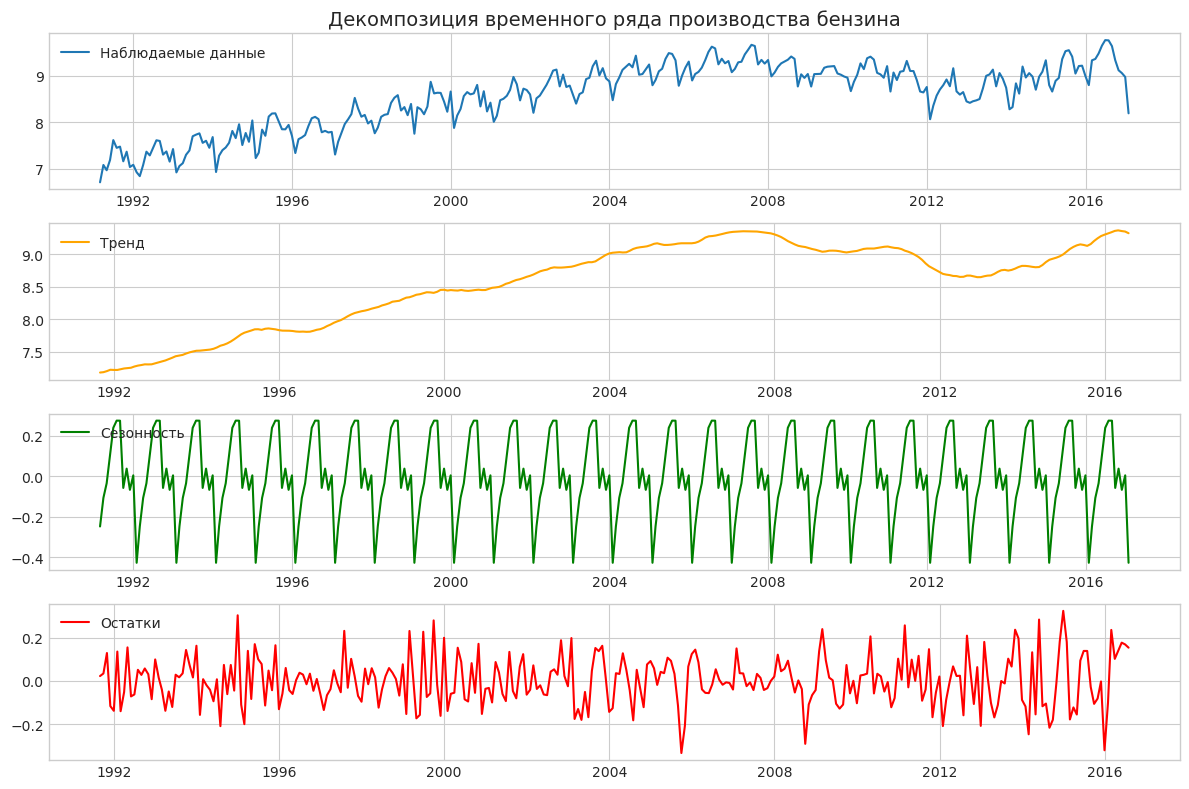

In [12]:
# Ваш код здесь
# 1. Выполните декомпозицию
decomposition = seasonal_decompose(gas_monthly['value'], model='additive', period=12)

# 2. Постройте график
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Наблюдаемые данные')
plt.legend(loc='upper left')
plt.title('Декомпозиция временного ряда производства бензина', fontsize=14)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='orange')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [13]:
# Ваш код здесь
# Проведите расширенный тест Дики-Фуллера для ряда gas_monthly['value']
result = adfuller(gas_monthly['value'].dropna())
print('Результаты теста Дики-Фуллера:')
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
print(f'Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value:.4f}')

# Вывод о стационарности
if result[1] <= 0.05:
    print('Вывод: Ряд стационарен (отвергаем нулевую гипотезу о наличии единичного корня)')
else:
    print('Вывод: Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)')

Результаты теста Дики-Фуллера:
ADF Statistic: -2.1978
p-value: 0.2071
Критические значения:
  1%: -3.4527
  5%: -2.8714
  10%: -2.5720
Вывод: Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)


**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

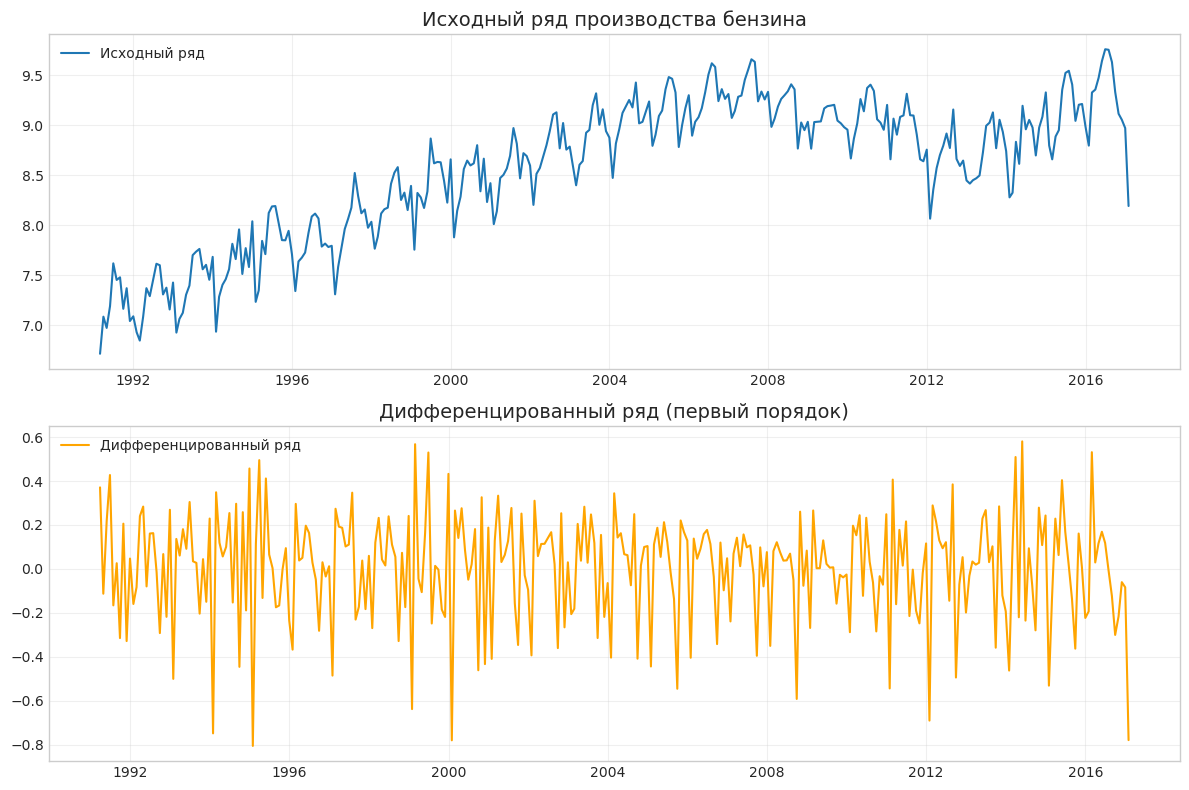

Размер исходного ряда: 312
Размер дифференцированного ряда: 311


In [14]:
# Ваш код здесь
# Примените дифференцирование первого порядка
gas_monthly_diff = gas_monthly['value'].diff().dropna()

# Построим график для сравнения
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(gas_monthly['value'], label='Исходный ряд')
plt.title('Исходный ряд производства бензина', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(gas_monthly_diff, label='Дифференцированный ряд', color='orange')
plt.title('Дифференцированный ряд (первый порядок)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Размер исходного ряда: {len(gas_monthly['value'])}")
print(f"Размер дифференцированного ряда: {len(gas_monthly_diff)}")

**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [15]:
# Ваш код здесь
# Проведите тест Дики-Фуллера для дифференцированного ряда
result_diff = adfuller(gas_monthly_diff)
print('Результаты теста Дики-Фуллера для дифференцированного ряда:')
print(f'ADF Statistic: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.4f}')
print(f'Критические значения:')
for key, value in result_diff[4].items():
    print(f'  {key}: {value:.4f}')

# Вывод о стационарности
if result_diff[1] <= 0.05:
    print('Вывод: Дифференцированный ряд стационарен')
else:
    print('Вывод: Дифференцированный ряд все еще нестационарен')
    

Результаты теста Дики-Фуллера для дифференцированного ряда:
ADF Statistic: -3.0639
p-value: 0.0293
Критические значения:
  1%: -3.4528
  5%: -2.8714
  10%: -2.5720
Вывод: Дифференцированный ряд стационарен


**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

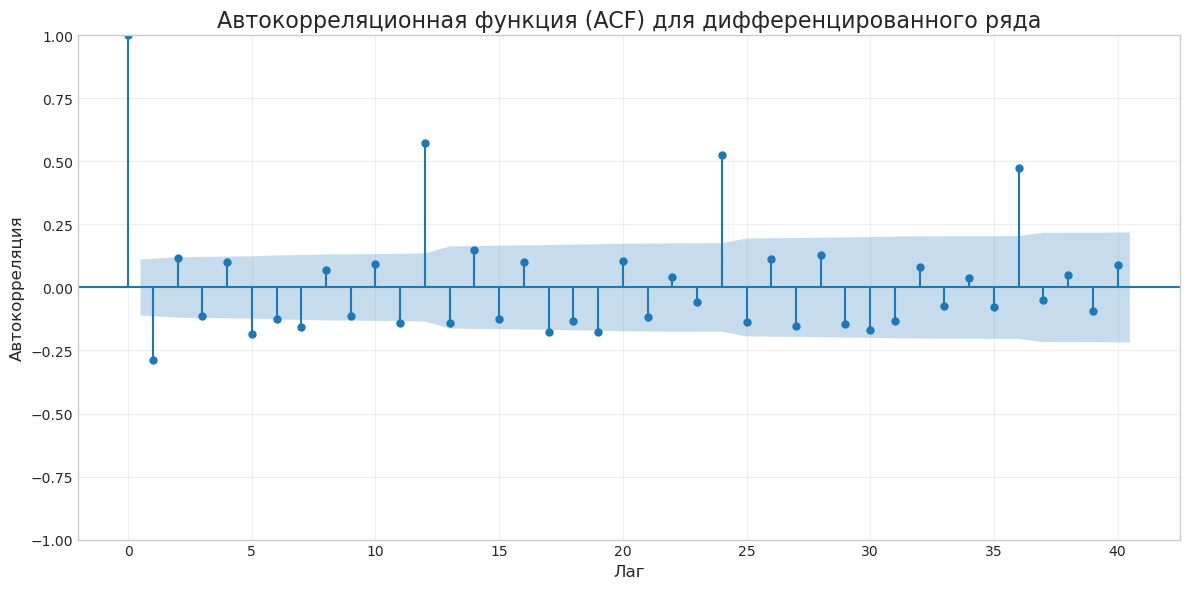

In [16]:
# Ваш код здесь
# Постройте график автокорреляционной функции (ACF) для стационарного ряда gas_monthly_diff
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(gas_monthly_diff, lags=40, ax=ax)
plt.title('Автокорреляционная функция (ACF) для дифференцированного ряда', fontsize=16)
plt.xlabel('Лаг', fontsize=12)
plt.ylabel('Автокорреляция', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

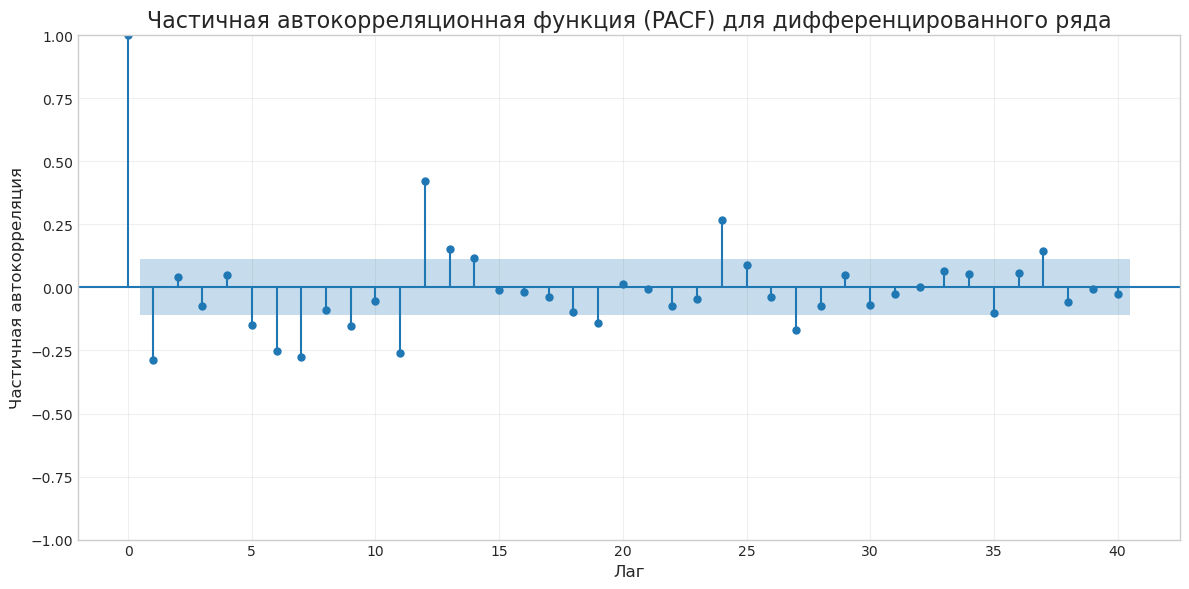

In [17]:
# Ваш код здесь
# Постройте график частичной автокорреляционной функции (PACF) для gas_monthly_diff
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(gas_monthly_diff, lags=40, ax=ax, method='ywm')
plt.title('Частичная автокорреляционная функция (PACF) для дифференцированного ряда', fontsize=16)
plt.xlabel('Лаг', fontsize=12)
plt.ylabel('Частичная автокорреляция', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

In [18]:
# Ваш код здесь
# Разделите gas_monthly['value'] на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года)
train_data = gas_monthly['value'][gas_monthly.index < '2015-01-01']
test_data = gas_monthly['value'][gas_monthly.index >= '2015-01-01']

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"Обучающая выборка: с {train_data.index[0].date()} по {train_data.index[-1].date()}")
print(f"Тестовая выборка: с {test_data.index[0].date()} по {test_data.index[-1].date()}")


Размер обучающей выборки: 287
Размер тестовой выборки: 25
Обучающая выборка: с 1991-02-28 по 2014-12-31
Тестовая выборка: с 2015-01-31 по 2017-01-31


**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [19]:
# Ваш код здесь
# 1. Создайте модель ARIMA
model = ARIMA(train_data, order=(2, 1, 2))

# 2. Обучите модель
model_fit = model.fit()

# 3. Выведите сводку
print(model_fit.summary())


/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.578
Date:                Mon, 08 Dec 2025   AIC                            -67.157
Time:                        08:56:38   BIC                            -48.877
Sample:                    02-28-1991   HQIC                           -59.830
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4035      0.087     -4.657      0.000      -0.573      -0.234
ar.L2          0.5965      0.086      6.903      0.000       0.427       0.766
ma.L1          0.1062      0.102      1.041      0.2

**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [20]:
# Ваш код здесь
# Сделайте прогноз на период, соответствующий тестовой выборке
forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Выведем первые и последние значения прогноза
print("Первые 5 значений прогноза:")
print(forecast.head())
print("\nПоследние 5 значений прогноза:")
print(forecast.tail())

Первые 5 значений прогноза:
2015-01-31    9.113515
2015-02-28    9.129117
2015-03-31    8.994589
2015-04-30    9.058178
2015-05-31    8.952277
Freq: ME, Name: predicted_mean, dtype: float64

Последние 5 значений прогноза:
2016-09-30    8.928923
2016-10-31    9.018995
2016-11-30    8.928920
2016-12-31    9.018992
2017-01-31    8.928920
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

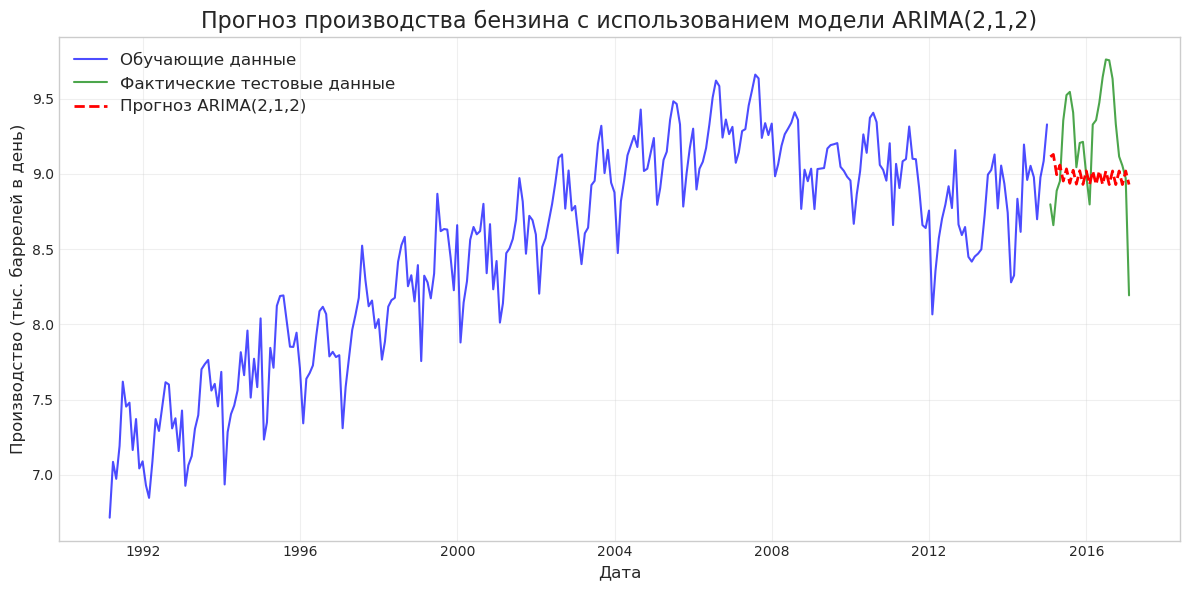

In [21]:
# Ваш код здесь
# Постройте график с обучающими данными, реальными тестовыми данными и прогнозом
plt.figure(figsize=(12, 6))

# Обучающие данные
plt.plot(train_data.index, train_data, label='Обучающие данные', color='blue', alpha=0.7)

# Фактические тестовые данные
plt.plot(test_data.index, test_data, label='Фактические тестовые данные', color='green', alpha=0.7)

# Прогноз
plt.plot(forecast.index, forecast, label='Прогноз ARIMA(2,1,2)', color='red', linestyle='--', linewidth=2)

plt.title('Прогноз производства бензина с использованием модели ARIMA(2,1,2)', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [22]:
# Ваш код здесь
# Рассчитайте метрику RMSE для оценки точности прогноза
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f'RMSE (Root Mean Squared Error): {rmse:.2f}')

# Также рассчитаем MAE для дополнительной оценки
mae = np.mean(np.abs(test_data - forecast))
print(f'MAE (Mean Absolute Error): {mae:.2f}')

# Рассчитаем процент ошибки
percentage_error = np.mean(np.abs((test_data - forecast) / test_data)) * 100
print(f'Средняя абсолютная процентная ошибка: {percentage_error:.2f}%')


RMSE (Root Mean Squared Error): 0.44
MAE (Mean Absolute Error): 0.36
Средняя абсолютная процентная ошибка: 3.93%


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [23]:
# Ваш код здесь
# Используйте модель для прогнозирования на 12 месяцев вперед
future_forecast = model_fit.forecast(steps=12)

# Создаем индекс для будущих дат
last_date = gas_monthly.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

print("Прогноз на 12 месяцев вперед:")
for date, value in zip(future_dates, future_forecast):
    print(f"{date.date()}: {value:.2f}")
    

<ipython-input-23-20aa8fe06b66>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')


Прогноз на 12 месяцев вперед:
2017-02-28: 9.11
2017-03-31: 9.13
2017-04-30: 8.99
2017-05-31: 9.06
2017-06-30: 8.95
2017-07-31: 9.03
2017-08-31: 8.94
2017-09-30: 9.02
2017-10-31: 8.93
2017-11-30: 9.02
2017-12-31: 8.93
2018-01-31: 9.02


**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

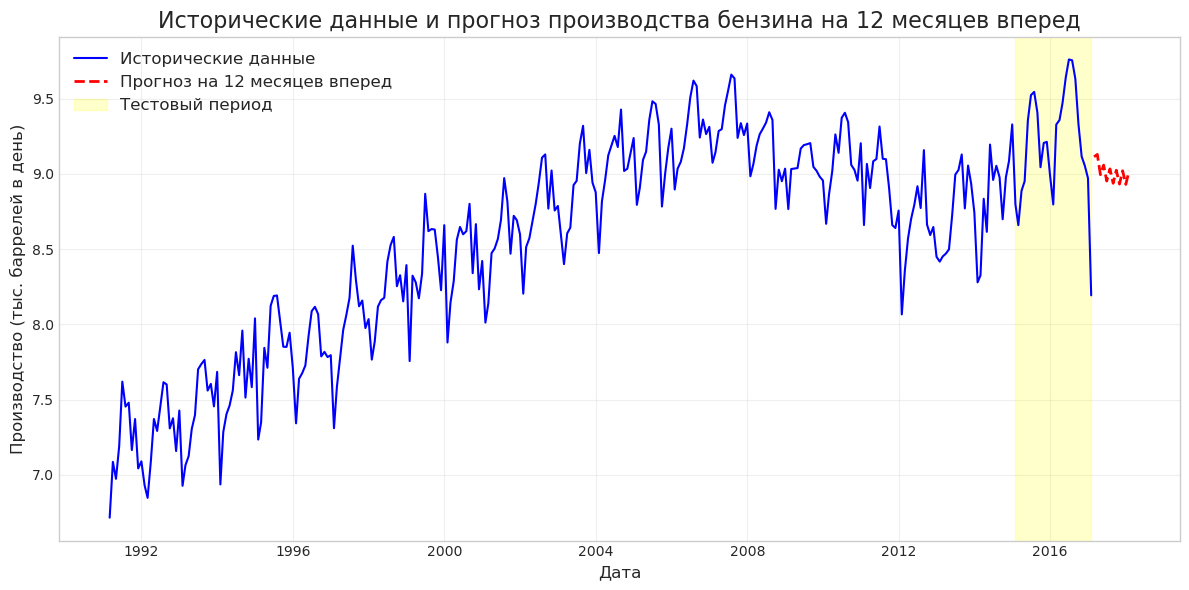

In [24]:
# Ваш код здесь
# Постройте график, включающий все исторические данные и прогноз на будущее
plt.figure(figsize=(12, 6))

# Все исторические данные
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исторические данные', color='blue')

# Прогноз на будущее
plt.plot(future_dates, future_forecast, label='Прогноз на 12 месяцев вперед', 
         color='red', linestyle='--', linewidth=2)

# Выделим тестовый период
test_start = test_data.index[0]
test_end = test_data.index[-1]
plt.axvspan(test_start, test_end, alpha=0.2, color='yellow', label='Тестовый период')

plt.title('Исторические данные и прогноз производства бензина на 12 месяцев вперед', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [25]:
unemployment_df = pd.read_csv('US_unemployment.csv', parse_dates=['date'], index_col='date')
gas_df = pd.read_csv('US_gasoline_production.csv', parse_dates=['date'], index_col='date')
gas_monthly = gas_df.resample('M').mean()
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

<ipython-input-25-efb1151d46d3>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas_df.resample('M').mean()


Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):
              value
date               
1991-02-28  6.71500
1991-03-31  7.08600
1991-04-30  6.97325
1991-05-31  7.19175
1991-06-30  7.61900


---
**Вариант 1:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2005 по 2010 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 6 месяцев.
4. **Стационарность:** Примените дифференцирование первого порядка и проведите тест Дики-Фуллера.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2014 года и сделайте прогноз на 12 шагов вперед.

---
**Вариант 2:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график всего временного ряда уровня безработицы.
3. **Декомпозиция:** Разложите ряд на тренд, сезонность и остаток.
4. **Корреляция:** Постройте график ACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,0) на данных до 2010 года и сделайте прогноз на 8 кварталов вперед.

---
**Вариант 3:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 1995 по 2000 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
4. **Стационарность:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.

---
**Вариант 4:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2000 года до конца.
3. **Стационарность:** Примените дифференцирование и проверьте на стационарность с помощью теста ADF.
4. **Корреляция:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2012 года, сделайте и визуализируйте прогноз на тестовом периоде (оставшиеся данные).

---
**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

---
**Вариант 6:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1990 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,2) на данных до 2005 года и сделайте прогноз на 10 кварталов.

---
**Вариант 7:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за последние 5 лет (с 2012 года).
3. **Стационарность:** Примените дифференцирование второго порядка (`.diff().diff()`) и проверьте на стационарность.
4. **Корреляция:** Постройте ACF для ряда после двойного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,2,1) на данных до 2015 года и оцените её RMSE на оставшихся данных.

---
**Вариант 8:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 8 кварталов (2 года).
4. **Стационарность:** Проведите тест ADF для исходного и дифференцированного рядов, сравните результаты.
5. **Прогноз:** Обучите модель ARIMA(0,1,1) на данных до 2008 года и сделайте прогноз на 12 кварталов.

---
**Вариант 9:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему значению.
3. **Декомпозиция:** Разложите исходный ежемесячный ряд на компоненты.
4. **Корреляция:** Постройте PACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(3,1,0) на данных до 2011 года и сделайте прогноз на 18 месяцев.

---
**Вариант 10:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1970 по 1985 год.
3. **Преобразование:** Примените логарифмическое преобразование (`np.log`) к ряду и постройте его график.
4. **Стационарность:** Проверьте на стационарность логарифмированный ряд после одного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов.

---
**Вариант 11:**
1. **Данные:** `gas_monthly`
2. **EDA:** Рассчитайте и постройте график годового скользящего среднего (окно 12).
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите модель ARIMA(1,1,1). Выведите `.summary()`.
5. **Оценка:** Разделите данные на train/test по 2013 году. Рассчитайте RMSE прогноза на тестовой выборке.

---
**Вариант 12:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию. Проанализируйте график сезонной компоненты.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Корреляция:** Постройте ACF для остатков.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2007 года и спрогнозируйте на 10 кварталов.

---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---
**Вариант 14:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график дифференцированного ряда.
3. **Корреляция:** Постройте PACF для дифференцированного ряда. Определите возможный порядок `p`.
4. **Моделирование:** Обучите модель ARIMA с порядком `p`, определённым на шаге 3, и `d=1`, `q=1`.
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед от конца имеющихся данных.

---
**Вариант 15:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию. Выведите первые 5 значений трендовой и сезонной компонент.
3. **Преобразование:** Рассчитайте процентное изменение от месяца к месяцу (`.pct_change()`) и постройте график.
4. **Стационарность:** Проверьте на стационарность ряд процентных изменений.
5. **Прогноз:** Обучите ARIMA(2,1,2) на данных до 2011 года и сделайте прогноз на 12 шагов.

---
**Вариант 16:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 2 (полгода).
3. **Корреляция:** Постройте ACF для дифференцированного ряда. Определите возможный порядок `q`.
4. **Моделирование:** Обучите модель ARIMA с порядком `q`, определённым на шаге 3, и `d=1`, `p=1`.
5. **Оценка:** Разделите данные по 2009 году. Рассчитайте RMSE модели на тестовой выборке.

---
**Вариант 17:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2008 по 2012 год.
3. **Декомпозиция:** Проведите декомпозицию и постройте график только для сезонной компоненты.
4. **Стационарность:** Проведите тест ADF на сезонной компоненте.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2010 года, спрогнозируйте на 12 шагов.

---
**Вариант 18:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1995 по 2005 год.
3. **Преобразование:** Рассчитайте скользящее стандартное отклонение (`.rolling(4).std()`).
4. **Корреляция:** Постройте ACF и PACF для исходного (недифференцированного) ряда.
5. **Прогноз:** Обучите ARIMA(3,1,1) на данных до 2011 года, сделайте прогноз на 8 кварталов.

---
**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

---
**Вариант 20:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график исходных данных и наложите на него скользящее среднее с окном 10.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Моделирование:** Обучите модель ARIMA(2,1,3) на данных до 2006 года.
5. **Прогноз:** Сделайте прогноз на 12 кварталов вперед.

---
**Вариант 21:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте данные за 2000-2004 гг.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 18 месяцев.
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,0) на данных до 2013 года, спрогнозируйте на 15 месяцев.

---
**Вариант 22:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Стационарность:** Проведите тест ADF на трендовой компоненте.
4. **Моделирование:** Обучите модель ARIMA(0,1,2) на данных до 2011 года.
5. **Оценка:** Сделайте прогноз на тестовом периоде (остальные данные) и рассчитайте RMSE.

---
**Вариант 23:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до квартальной частоты (`'Q'`) по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для этого агрегированного ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на агрегированном ряде (до 2014 года).
5. **Прогноз:** Сделайте прогноз на 4 квартала вперед.

---
**Вариант 24:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1985 по 1995 год.
3. **Преобразование:** Рассчитайте скользящую медиану с окном 3 (`.rolling(3).median()`).
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2004 года и сделайте прогноз на 8 кварталов.

---
**Вариант 25:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте остатки (residuals) после декомпозиции.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите модель ARIMA(3,1,2) на данных до 2012 года.
5. **Прогноз:** Сделайте прогноз на 10 месяцев вперед.

---
**Вариант 26:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему.
3. **Корреляция:** Постройте ACF для годового ряда.
4. **Моделирование:** Обучите ARIMA(1,1,0) на годовом ряде (до 2010 года).
5. **Прогноз:** Сделайте прогноз на 5 лет вперед.

---
**Вариант 27:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график скользящего среднего с окном 3 месяца.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,0) на данных до 2013 года.
5. **Оценка:** Рассчитайте RMSE модели на тестовом периоде (данные с 2013 года).

---
**Вариант 28:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2005 года до конца.
3. **Декомпозиция:** Проведите декомпозицию и постройте график трендовой компоненты.
4. **Стационарность:** Проведите тест ADF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2009 года и сделайте прогноз на 8 кварталов.

---
**Вариант 29:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за первые 10 лет (до 2001 года).
3. **Преобразование:** Рассчитайте логарифм ряда и примените к нему дифференцирование.
4. **Корреляция:** Постройте PACF для этого преобразованного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов.

---
**Вариант 30:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите ARIMA(2,1,2) на данных до 2012 года.
5. **Прогноз:** Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE.

---
**Вариант 31:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график ряда, агрегированного до квартальной частоты по медиане.
3. **Стационарность:** Проведите тест ADF для этого квартального ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на квартальном ряде (до 2012 года).
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед.

---
**Вариант 32:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 5.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,1) на данных до 2007 года.
5. **Прогноз:** Сделайте прогноз на 10 кварталов.

---
**Вариант 33:**
1. **Данные:** `gas_monthly`
2. **EDA:** Декомпозируйте ряд. Постройте график остатков.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите ARIMA(2,1,3) на данных до 2015 года.
5. **Прогноз:** Сделайте прогноз на 12 месяцев вперед.

---
**Вариант 34:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1999 по 2009 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 6.
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(3,1,0) на данных до 2010 года и спрогнозируйте на 8 кварталов.

---
**Вариант 35:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1980 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для ряда, дифференцированного дважды (`.diff().diff()`).
5. **Прогноз:** Обучите модель ARIMA(2,2,2) на данных до 2008 года и спрогнозируйте следующие 10 кварталов.


ВАРИАНТ 29 - ИНДИВИДУАЛЬНОЕ ЗАДАНИЕ
1. Используем данные gas_monthly (ежемесячное производство бензина в США)

2. EDA: График данных за первые 10 лет (до 2001 года)


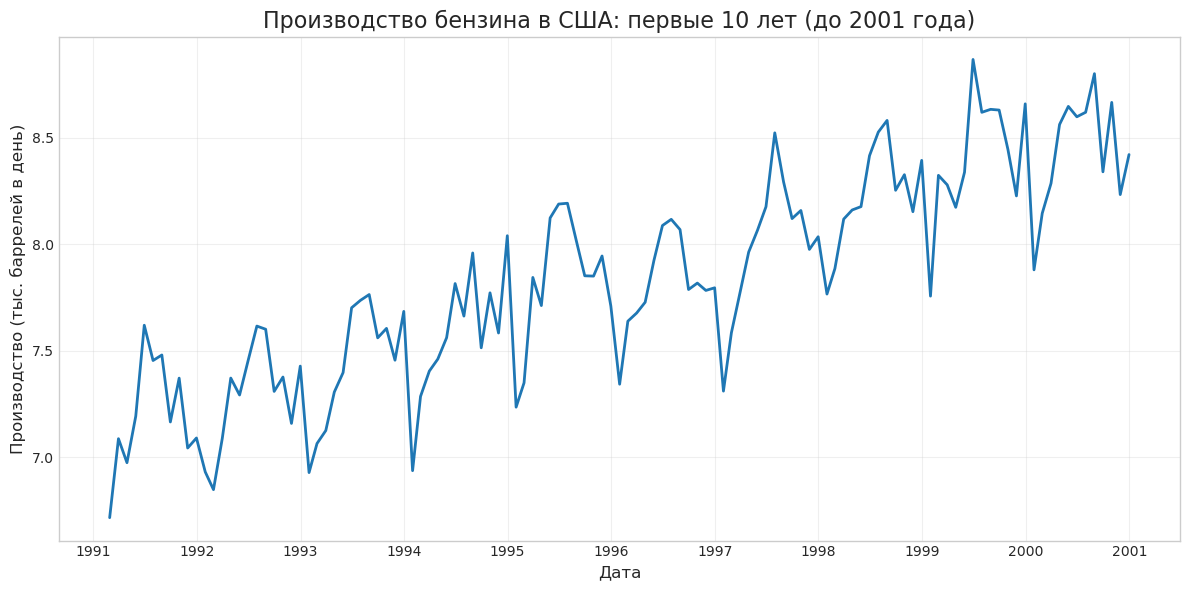

Период: с 1991-02-28 по 2000-12-31
Количество наблюдений: 119
Среднее: 7.83
Минимум: 6.71
Максимум: 8.87

3. Преобразование: Логарифм + дифференцирование


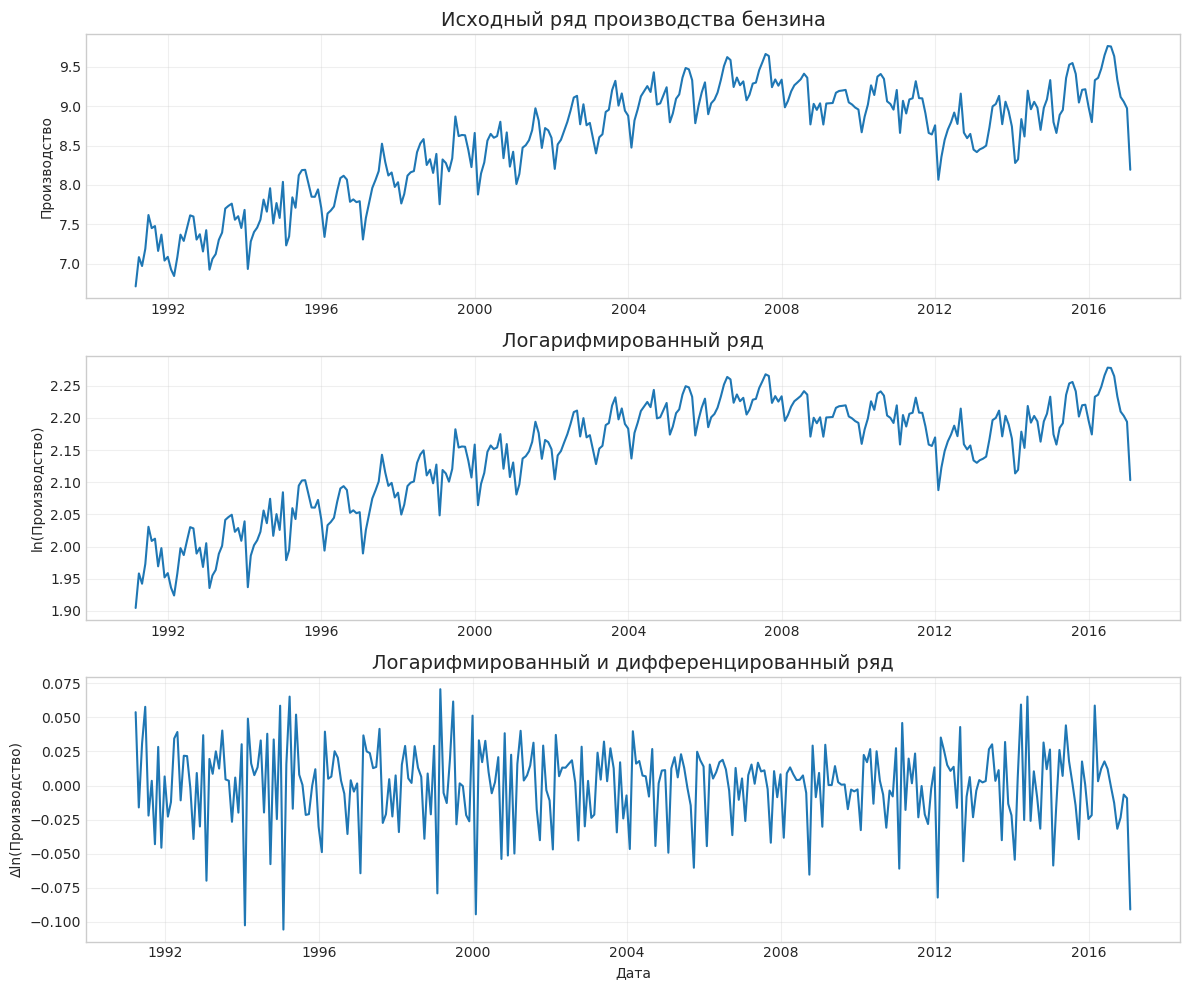

ADF тест для логарифмированного и дифференцированного ряда:
  ADF Statistic: -3.0623
  p-value: 0.0295
  Вывод: Ряд стационарен (p-value < 0.05)

4. Корреляция: PACF для преобразованного ряда


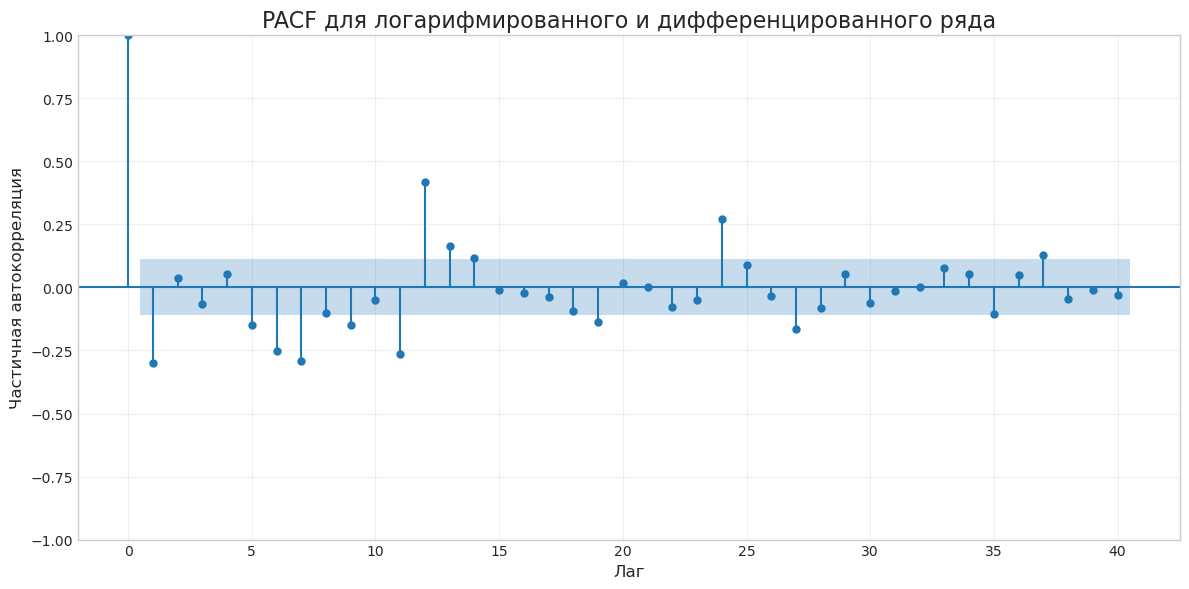


5. Прогноз: ARIMA(2,1,2) на данных до 2010 года с прогнозом на 12 шагов
Обучающая выборка (до 2010): 227 записей
Тестовая выборка (с 2010): 85 записей


/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Сводка модели ARIMA(2,1,2):
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  227
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  34.303
Date:                Mon, 08 Dec 2025   AIC                            -58.605
Time:                        08:56:46   BIC                            -41.503
Sample:                    02-28-1991   HQIC                           -51.703
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4096      0.099     -4.158      0.000      -0.603      -0.217
ar.L2          0.5904      0.098      6.002      0.000       0.398       0.783
ma.L1          0.1106  

<ipython-input-26-66d7733de775>:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_data_2010.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')



Прогноз на 12 месяцев вперед:
Месяц  1 (2010-01-31): 8.92
Месяц  2 (2010-02-28): 9.05
Месяц  3 (2010-03-31): 8.97
Месяц  4 (2010-04-30): 9.08
Месяц  5 (2010-05-31): 8.99
Месяц  6 (2010-06-30): 9.09
Месяц  7 (2010-07-31): 9.00
Месяц  8 (2010-08-31): 9.09
Месяц  9 (2010-09-30): 9.00
Месяц 10 (2010-10-31): 9.09
Месяц 11 (2010-11-30): 9.00
Месяц 12 (2010-12-31): 9.09


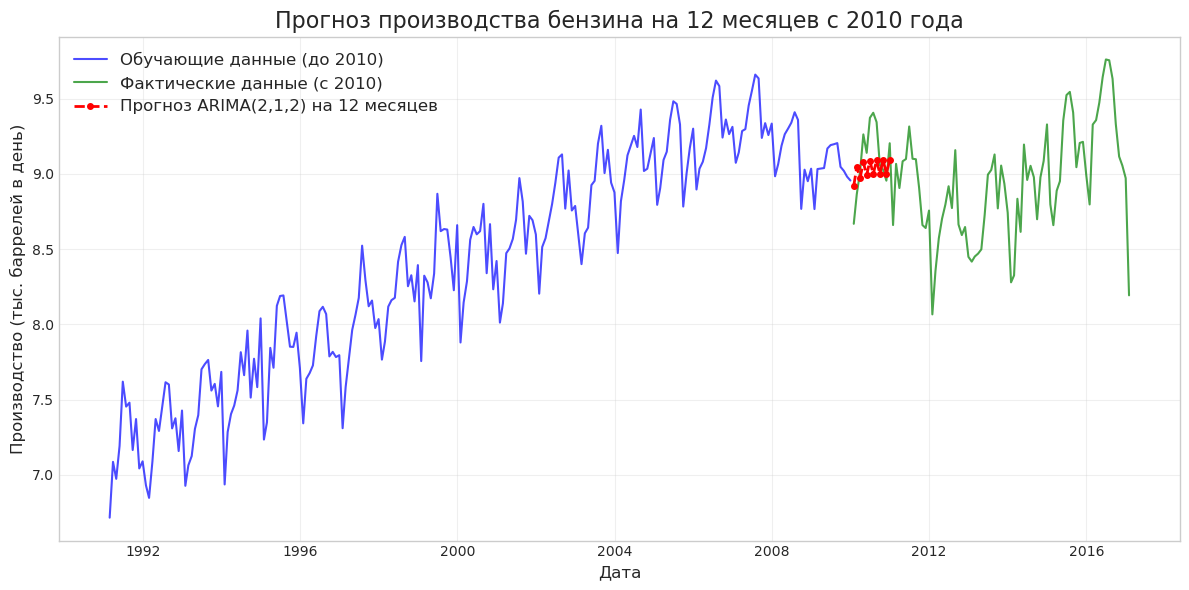


Оценка точности прогноза (первые 12 месяцев):
RMSE: 0.20
MAE: 0.17
MAPE: 1.86%


In [26]:
# =============================================
# ВАРИАНТ 29 - ИНДИВИДУАЛЬНОЕ ЗАДАНИЕ
# =============================================
print("=" * 60)
print("ВАРИАНТ 29 - ИНДИВИДУАЛЬНОЕ ЗАДАНИЕ")
print("=" * 60)

# 1. Данные: gas_monthly (у нас уже есть)
print("1. Используем данные gas_monthly (ежемесячное производство бензина в США)")

# 2. EDA: Постройте график данных за первые 10 лет (до 2001 года)
print("\n2. EDA: График данных за первые 10 лет (до 2001 года)")

# Фильтруем данные до 2001 года
gas_first_10_years = gas_monthly[gas_monthly.index < '2001-01-01']

plt.figure(figsize=(12, 6))
plt.plot(gas_first_10_years.index, gas_first_10_years['value'], linewidth=2)
plt.title('Производство бензина в США: первые 10 лет (до 2001 года)', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Период: с {gas_first_10_years.index[0].date()} по {gas_first_10_years.index[-1].date()}")
print(f"Количество наблюдений: {len(gas_first_10_years)}")
print(f"Среднее: {gas_first_10_years['value'].mean():.2f}")
print(f"Минимум: {gas_first_10_years['value'].min():.2f}")
print(f"Максимум: {gas_first_10_years['value'].max():.2f}")

# 3. Преобразование: Рассчитайте логарифм ряда и примените к нему дифференцирование
print("\n3. Преобразование: Логарифм + дифференцирование")

gas_log = np.log(gas_monthly['value'])
gas_log_diff = gas_log.diff().dropna()

# Визуализация
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Исходный ряд
axes[0].plot(gas_monthly.index, gas_monthly['value'])
axes[0].set_title('Исходный ряд производства бензина', fontsize=14)
axes[0].set_ylabel('Производство')
axes[0].grid(True, alpha=0.3)

# Логарифмированный ряд
axes[1].plot(gas_monthly.index, gas_log)
axes[1].set_title('Логарифмированный ряд', fontsize=14)
axes[1].set_ylabel('ln(Производство)')
axes[1].grid(True, alpha=0.3)

# Логарифмированный и дифференцированный ряд
axes[2].plot(gas_log_diff.index, gas_log_diff)
axes[2].set_title('Логарифмированный и дифференцированный ряд', fontsize=14)
axes[2].set_ylabel('Δln(Производство)')
axes[2].set_xlabel('Дата')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стационарности
result_log_diff = adfuller(gas_log_diff.dropna())
print(f"ADF тест для логарифмированного и дифференцированного ряда:")
print(f"  ADF Statistic: {result_log_diff[0]:.4f}")
print(f"  p-value: {result_log_diff[1]:.4f}")
if result_log_diff[1] <= 0.05:
    print("  Вывод: Ряд стационарен (p-value < 0.05)")
else:
    print("  Вывод: Ряд нестационарен (p-value > 0.05)")

# 4. Корреляция: Постройте PACF для этого преобразованного ряда
print("\n4. Корреляция: PACF для преобразованного ряда")

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(gas_log_diff, lags=40, ax=ax, method='ywm')
plt.title('PACF для логарифмированного и дифференцированного ряда', fontsize=16)
plt.xlabel('Лаг', fontsize=12)
plt.ylabel('Частичная автокорреляция', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Прогноз: Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов
print("\n5. Прогноз: ARIMA(2,1,2) на данных до 2010 года с прогнозом на 12 шагов")

# Разделяем данные
train_data_2010 = gas_monthly['value'][gas_monthly.index < '2010-01-01']
test_data_2010 = gas_monthly['value'][gas_monthly.index >= '2010-01-01']

print(f"Обучающая выборка (до 2010): {len(train_data_2010)} записей")
print(f"Тестовая выборка (с 2010): {len(test_data_2010)} записей")

# Обучаем модель ARIMA(2,1,2)
model_arima_212 = ARIMA(train_data_2010, order=(2, 1, 2))
model_fit_212 = model_arima_212.fit()

print("\nСводка модели ARIMA(2,1,2):")
print(model_fit_212.summary())

# Прогноз на 12 шагов вперед
forecast_12_steps = model_fit_212.forecast(steps=12)
forecast_index = pd.date_range(start=train_data_2010.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

print("\nПрогноз на 12 месяцев вперед:")
for i, (date, value) in enumerate(zip(forecast_index, forecast_12_steps), 1):
    print(f"Месяц {i:2d} ({date.date()}): {value:.2f}")

# Визуализация прогноза
plt.figure(figsize=(12, 6))

# Обучающие данные
plt.plot(train_data_2010.index, train_data_2010, label='Обучающие данные (до 2010)', color='blue', alpha=0.7)

# Тестовые данные
plt.plot(test_data_2010.index, test_data_2010, label='Фактические данные (с 2010)', color='green', alpha=0.7)

# Прогноз
plt.plot(forecast_index, forecast_12_steps, label='Прогноз ARIMA(2,1,2) на 12 месяцев', 
         color='red', linestyle='--', linewidth=2, marker='o', markersize=4)

plt.title('Прогноз производства бензина на 12 месяцев с 2010 года', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство (тыс. баррелей в день)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Оценка точности (первые 12 месяцев тестовой выборки)
if len(test_data_2010) >= 12:
    actual_12 = test_data_2010[:12]
    forecast_12 = forecast_12_steps[:12]
    
    rmse = np.sqrt(mean_squared_error(actual_12, forecast_12))
    mae = np.mean(np.abs(actual_12 - forecast_12))
    mape = np.mean(np.abs((actual_12 - forecast_12) / actual_12)) * 100
    
    print("\nОценка точности прогноза (первые 12 месяцев):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")